In [2]:
import numpy as np
from scipy.stats import poisson
from functools import lru_cache
import matplotlib.pyplot as plt

import importlib
import MDP
from MDP import HomoMDP

importlib.reload(MDP)

<module 'MDP' from 'i:\\My Drive\\ACSYON\\M2\\reinforcement-learning\\MDP.py'>

# Jack's Car Rental

##### Analytical solution

1. States are $\begin{bmatrix} x \\ y\end{bmatrix}$, where $0 \le x, y \le 20$, where $x, y$ are number of cars at location $1$ and $2$, respectively, right before Jack moves cars.
2. Actions: $\mathcal{A}\left(\begin{bmatrix} x \\ y\end{bmatrix}\right) = \{n : -\min(5, y) \le n \le  \min(5, x) \}$, meaning Jack moves $a$ cars from location 1 to location 2.

Let $X_t, R_t$ be the number of cars at location 1 at $t$-th night and the credit Jack receives that this time, before Jack moves cars. Let $X_{\mathrm{rented}}$ and $X_{\mathrm{returned}}$ be the number of cars rented and returned during the day. Let $Y_t$, $S_t$, $Y_{\mathrm{rented}}$ and $Y_{\mathrm{returned}}$ have similar roles, but for location 2.

By assumptions,
$$X_{\mathrm{rented}}\sim \mathrm{Pois}(3), X_{\mathrm{returned}}\sim \mathrm{Pois}(4),$$ 
$$Y_{\mathrm{rented}}\sim \mathrm{Pois}(3), Y_{\mathrm{returned}}\sim \mathrm{Pois}(2).$$

We have

$$X_{t+1} = \min\{\max\{X_t - a - X_{\mathrm{rented}}, 0\} + X_{\mathrm{returned}}, 20\},$$
$$Y_{t+1} = \min\{\max\{Y_t + a - Y_{\mathrm{rented}}, 0\} + Y_{\mathrm{returned}}, 20\}.$$

We will compute

$$
\begin{aligned}
p_1(x_{t+1}| x_t, a)
&:= p(X_{t+1}=x_{t+1} | X_t = x_t, A_t = a)\\
& = \mathbb{P}(\max\{x_t - a - X_{\mathrm{rented}}, 0\} + X_{\mathrm{returned}} \ge 20).
\end{aligned}
$$

If $x_{t+1} = 20$, then

$$
\begin{aligned}
p_1(x_{t+1}| x_t, a) 
&= \mathbb{P}(\max\{x_t - a - X_{\mathrm{rented}}, 0\} + X_{\mathrm{returned}} \ge 20)\\
& = \sum\limits_{n=0}^{x_t-a}\mathbb{P}(X_{\mathrm{rented}}=n)\mathbb{P}(x_t-a- n + X_{\mathrm{returned}} \ge 20) + \mathbb{P}(X_{\mathrm{rented}}>x_t-a)\mathbb{P}(X_{\mathrm{returned}} \ge 20).
\end{aligned}
$$

If $x_{t+1} <20$, then
$$
\begin{aligned}
p_1(x_{t+1}| x_t, a) 
&= \mathbb{P}(x_{t+1} = \max\{x_t - a - X_{\mathrm{rented}}, 0\} + X_{\mathrm{returned}})\\
& = \sum\limits_{n=0}^{x_t-a}\mathbb{P}(X_{\mathrm{rented}}=n)\mathbb{P}(x_t-a- n + X_{\mathrm{returned}} = x_{t+1}) + \mathbb{P}(X_{\mathrm{rented}}>x_t-a)\mathbb{P}(X_{\mathrm{returned}} = x_{t+1}).
\end{aligned}
$$

Also,

$$
\begin{aligned}
R_t 
&= 10\min\{x_t-a, X_{\mathrm{rented}}\}.
\end{aligned}
$$

Hence,

$$
\begin{aligned}
r_1(x_{t+1}|x_t,a) 
&:= \mathbb{E}[R_t]\\
&= 10\left[\sum\limits_{n=0}^{x_t-a}\mathbb{P}(X_{\mathrm{rented}}=n)\cdot n + \mathbb{P}(X_{\mathrm{rented}}>x_t-a)(x_t-a)\right].
\end{aligned}
$$

Similarly for location 2. Therefore, 

$$p\left(\begin{bmatrix} x_t \\ y_t\end{bmatrix}\left|\begin{bmatrix} x_t \\ y_t\end{bmatrix}, a\right.\right) = p_1(x_{t+1}|x_t,a)p_2(y_{t+1}|y_t,a),$$

$$r_t = r_1(x_{t+1}|x_t,a) + r_2(y_{t+1}|y_t,a) - 2|a|.$$

##### Implementation

In [3]:
@lru_cache(None)
def pois(lam, start, end = None):
  if end is None:  
    return poisson.pmf(start, lam)
  if end != np.inf:
    return poisson.cdf(end, lam) - poisson.cdf(start-1, lam)
  
  return 1 - poisson.cdf(start-1, lam)

In [4]:
# Transitions and rewards

def p1(x2, x1, a):
  p_rent = lambda start, end = None: pois(3, start, end)
  p_return = lambda start, end = None: pois(3, start, end)

  if x2 == 20:
    return np.sum([p_rent(i)*p_return(x2+i+a-x1, np.inf) for i in range(0, x1-a+1)]) \
              + p_rent(x1-a+1, np.inf)*p_return(x2+a-x1, np.inf)
  
  return np.sum([p_rent(i)*p_return(x2+i+a-x1) for i in range(0, x1-a+1)]) + (1-p_rent(0, x1-a))*p_return(x2+a-x1)

def r1(x2, x1, a):
  p_rent = lambda start, end = None: pois(3, start, end)
  
  return 10*(np.sum([p_rent(i)*i for i in range(0, x1-a+1)]) + p_rent(x1-a+1, np.inf)*(x1-a)) 



def p2(y2, y1, a):
  p_rent = lambda start, end = None: pois(4, start, end)
  p_return = lambda start, end = None: pois(2, start, end)
  
  if y2 == 20:
    return np.sum([p_rent(i)*p_return(y2+i-a-y1, np.inf) for i in range(0, y1-a+1)]) \
      + p_rent(y2-a+1, np.inf)*p_return(y2-a-y1, np.inf)
  
  return np.sum([p_rent(i)*p_return(y2+i-a-y1) for i in range(0, y1-a+1)]) \
      + p_rent(y2-a+1, np.inf)*p_return(y2-a-y1)

def r2(y2, y1, a):
  p_rent = lambda start, end = None: pois(4, start, end)

  return 10*(np.sum([p_rent(i)*i for i in range(0, y1+a+1)]) + p_rent(y1+a+1, np.inf)*(y1+a))

In [5]:
# Cache functions in dictionaries for faster access
p1_dict = {}
r1_dict = {}

for x1 in range(0, 21):
  for x2 in range(0, 21):
    for a in range(-5, np.min([5, x1])+1):
      p1_dict[x1, x2, a] = p1(x2, x1, a)
      r1_dict[x1, x2, a] = r1(x2, x1, a)

p2_dict = {}
r2_dict = {}

for y1 in range(0, 21):
  for y2 in range(0, 21):
    for a in range(-np.min([5, y1]), 6):
      p2_dict[y1, y2, a] = p2(y2, y1, a)
      r2_dict[y1, y2, a] = r2(y2, y1, a)


In [6]:
# Initiate the MDP

states = [(x, y) for x in range(0, 21) for y in range(0, 21)]
actions = [a for a  in range(-5, 6)]

responses = {}
for state in states:
  for action in range(-np.min([5, state[1]]), np.min([5, state[0]])+1):
    responses[state, action] = [(next_state, 
                                p1_dict[state[0], next_state[0], action]*p2_dict[state[1], next_state[1], action],
                                r1_dict[state[0], next_state[0], action]+r2_dict[state[1], next_state[1], action]-2*np.abs(a)
                                        )
                                  for next_state in states]


In [7]:
mdp = HomoMDP(name="Jack's Car Rental", 
          states=states, 
          actions=actions, 
          responses=responses)

In [8]:
best_policy = mdp.best_policy(method="policy_iteration",
                              discount=0.9, 
                              eps=1e-4, 
                              max_iter=100)

Policy evaluation: converged after 23 iterations
Policy evaluation: converged after 60 iterations
Policy evaluation: converged after 59 iterations
Policy evaluation: converged after 59 iterations
Best policy: converged after 3 iterations


##### Result

From the heatmap below, the best policy is to move cars from location 1 to location 2 when there are enough in some sense. This is understandable, since from the distributions of rental and return, location 1 has more returned cars than rented cars in average.

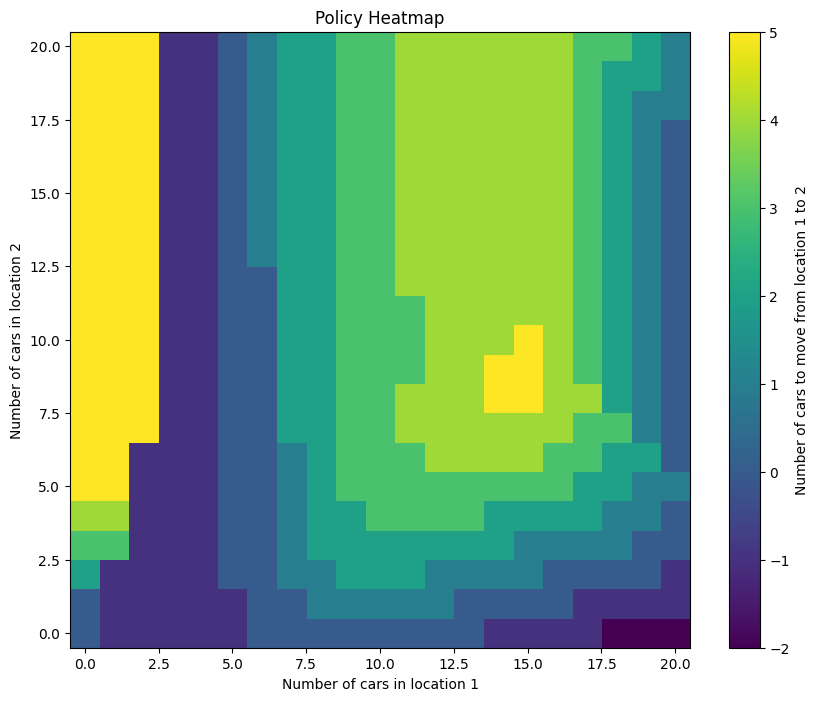

In [9]:
# Extract unique x and y values
x_vals = sorted(set([key[0] for key in best_policy.keys()]))
y_vals = sorted(set([key[1] for key in best_policy.keys()]))

# Create a 2D array to hold the policy values
policy_grid = np.zeros((len(x_vals), len(y_vals)))

# Fill the policy grid with corresponding policy values
for (x, y), value in best_policy.items():
    policy_grid[x, y] = value

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(policy_grid, cmap='viridis', origin='lower', aspect='auto')

# Add color bar and labels
plt.colorbar(label='Number of cars to move from location 1 to 2')
plt.xlabel('Number of cars in location 1')
plt.ylabel('Number of cars in location 2')
plt.title('Policy Heatmap')

plt.show()

# Gambler's Problem

1. States: ${1,\ldots, 99}$
2. Actions: $\mathcal{A}(s) = \{1,\ldots, \min(s, 100-s)\}$
3. Responses: $(s, a) \Rightarrow  [(s+a, p_h, \mathbf{1}_{s+a=100}), (s-a,1-p_h,0)]$

In [39]:
p = 0.4

In [40]:
states = list(range(0, 101))
actions = list(range(1, 100))

responses = {}
for state in states:
  for action in range(1, np.min([state, 100-state])+1):
    win = (state+action, p, 1) if state+action == 100 else (state+action, p, 0)
    lose = (state-action, (1-p), 0)
    responses[state, action] = [win, lose]

In [41]:
mdp = HomoMDP(name="Gambler",
          states=states,
          actions=actions,
          responses=responses,
          absorbing_states=[0, 100])
policy = mdp.best_policy(method='value_iteration')

Value iteration: converged after 11 iterations
Last value {0: 0, 1: 0.002031616000000001, 2: 0.005079040000000002, 3: 0.009125232640000001, 4: 0.012791971840000003, 5: 0.017327718400000004, 6: 0.022813081600000003, 7: 0.02773909504000001, 8: 0.032121487360000006, 9: 0.03764224000000001, 10: 0.04331929600000001, 11: 0.05031755776000001, 12: 0.05735120896000001, 13: 0.06521896960000001, 14: 0.06934773760000001, 15: 0.07439663104000002, 16: 0.08051605504000002, 17: 0.08658534400000001, 18: 0.09410560000000001, 19: 0.10313138176000002, 20: 0.10851057664000002, 21: 0.1159512064, 22: 0.12579389440000002, 23: 0.13357072384000004, 24: 0.14385577984000003, 25: 0.16000000000000003, 26: 0.16304742400000002, 27: 0.16761856000000003, 28: 0.17368784896, 29: 0.17918795776000002, 30: 0.18599157760000004, 31: 0.1942196224, 32: 0.20160864256000002, 33: 0.20818223104000003, 34: 0.21646336000000002, 35: 0.22497894400000004, 36: 0.23547633664000003, 37: 0.24602681344000002, 38: 0.2578284544, 39: 0.26402160

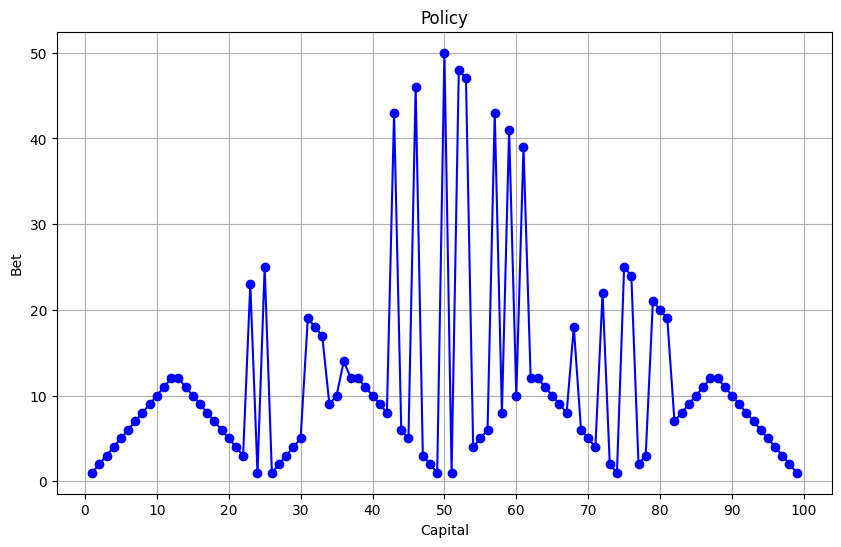

In [42]:
# Prepare data for plotting
x = list(policy.keys())
y = list(policy.values())

# Filter out None values for plotting
x_filtered = [x[i] for i in range(len(y)) if y[i] is not None]
y_filtered = [y[i] for i in range(len(y)) if y[i] is not None]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_filtered, y_filtered, marker='o', linestyle='-', color='b')
plt.title('Policy')
plt.xlabel('Capital')
plt.ylabel('Bet')
plt.xticks(range(0, 101, 10))  # Set x-ticks at intervals of 10
plt.grid()
plt.show()